## Tissue cartography with `blender_tisssue_cartography`

Tissue cartography (TC) is a tool for analyzing 3d biological image data by taking advantage of the laminar, sheet-like organization of many biological tissues. Tissue cartography extracts a surface of interest (SOI) from the volumetric image data, for example, the tube-like structure of the developing fly gut, and cartographically projects it into a 2d plane (see figure below, from [Mitchell & Cislo 2023](https://doi.org/10.1038/s41592-023-02081-w)). This is extremely helpful for both data visualization and data analysis, for example cell tracking.
 
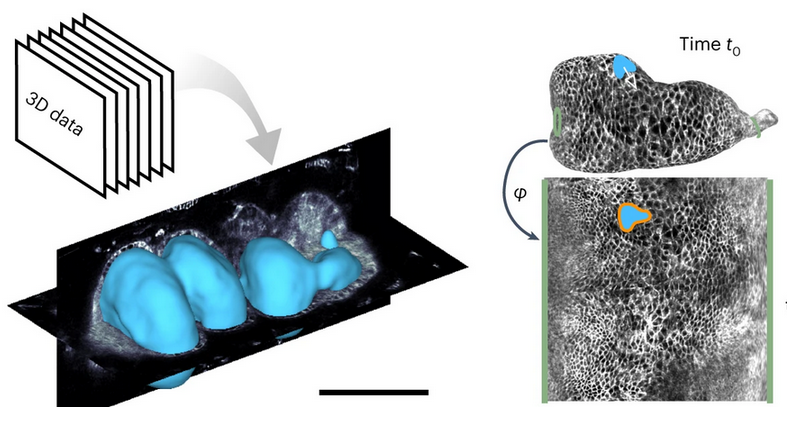

Tissue cartography was proposed by [Heemskerk & Streichan 2015](https://doi.org/10.1038/nmeth.3648) (ImSAnE software package). See also  [Mitchell & Cislo 2023](https://doi.org/10.1038/s41592-023-02081-w) (TubULAR software package) and [Herbert et al. 2021](https://doi.org/10.1186/s12915-021-01037-w) (LocalZProjector software package).

However, these existing tools for tissue cartography are either limited in the type of geometries they can handle, or difficult for non-experts to use and build upon.
 `blender_tisssue_cartography` is a set of Python tools, template analysis pipelines, and tutorials to do tissue cartography using the popular 3D creation software Blender. `blender_tisssue_cartography` makes tissue cartography user-friendly via simple, modular Python code, Blender’s graphical user interface, and powerful algorithms from the computer graphics community.

You can use `blender_tissue_cartography` in two forms:

1. The `blender_tissue_cartography` python library

2.  The `blender_tissue_cartography` blender add-on

For sophisticated use cases (dynamic datasets, custom computer vision operation), or automated pipeline, use the python library. Most users though can start with the blender add-on, which allows you to carry out almost all steps of the tissue cartography pipeline within blender's graphical user interface.

`blender_tisssue_cartography` also features a general-purpose pipeline for dynamic surfaces from timelapse microscopy in which the user graphically defines a cartographic projection for a single _key frame_, which is propagated to all other frames via robust surface-to-surface registration algorithms (tutorial 9, "Time-lapse imaging and dynamic surfaces").
A differential geometry module allows to analyze tissue flows and surface geometry dynamics (tutorial 10, "3D analysis and differential geometry").

## Tissue cartography workflow

The TC workflow begins with a volumetric recording, for example, a $z$-stack recorded on a confocal microscope. Let's consider first the case of a single recording with a single time point. TC comprises the following steps:

1. **Segmentation**: volumetric image $\mapsto$ 3d segmentation. From the volumetric image - a `.tif` file , the user creates a 3d segmentation, also a `.tif` file with values from 0-1. This segmentation divides the image into "inside" and "outside", and the SOI is defined as the boundary.

   - Note: not all surfaces can be represented as the boundary of a volume. One can also directly segment out the SOI (and use a different algorithm below in step 2).
    
3. **Meshing**: 3d segmentation $\mapsto$ surface mesh. A polygonal mesh of the segmentation boundary is computed, representing the surface of interest.

4. **UV mapping**: Polygonal mesh $\mapsto$ cartographic plane. A map from the mesh to a cartographic plane is generated (parametrized by coordinates $u, v$, to distinguish from the $x,y,z$ 3d coordinates).

5. **Projection**: volumetric image + polygonal mesh + UV map $\mapsto$ projected image. The volumetric image data is interpolated onto the UV cartographic plane using the 3d positions from the triangular mesh, creating a 2d projection of the 3d image data ("pullback").
    - **Multi layers**: to capture the whole thickness of a tissue sheet, one typically creates multiple projections using a version of the triangular mesh that is shifted along the local normal direction "inwards" and "outwards" (figure from [Heemskerk & Streichan 2015](https://doi.org/10.1038/nmeth.3648)):

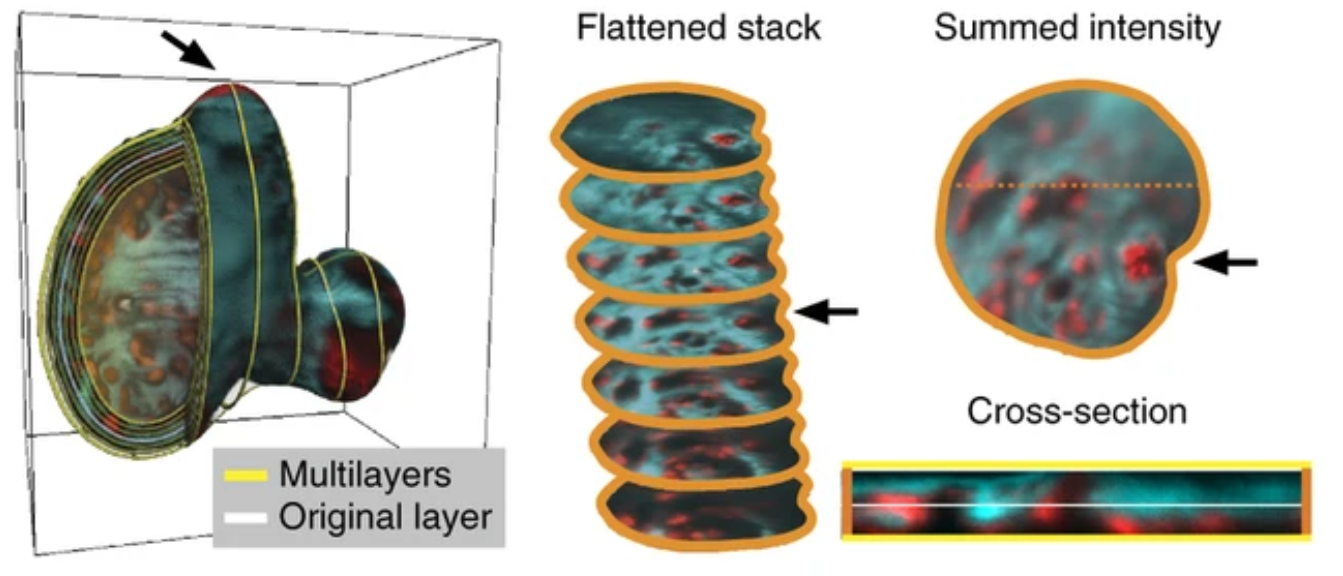

6. **Analysis and visualization**: with the projected data in hand, we can visualize it in 3D, or analyse it in 2D (e.g. segment cells), computationally correcting for the distortion of the projection.

7. **Batch processing**: batch process multiple 3D images, for example frames of a movie.

**These steps will be explained in detail as you go through the following tutorials.**

## Design principles of  `blender_tisssue_cartography`

1. **[Blender](https://www.blender.org/) for graphical, interactive workflows** - blender is a widely used, open-source program for 3D creation and contains advanced tools for mesh editing, UV mapping, and 3D visualization within a well-documented GUI. All of the main functionalities are available from within a Blender add-on - no programming knowledge necessary.
2. **File-based encapsulation** - each step in the pipeline terminates in a single data file (e.g. a `.obj` mesh, a `.tif` 3d segmentation), with all subsequent steps only depending on that data file. This means you can easily switch out the tools used for each step.
3. **Python library + template Jupyter notebooks**. For sophisticated users, the `blender_tissue_cartography` python library allows creating custom and automatized pipelines. Template / tutorial jupyter notebooks are provided as starting points.
4. **UV transfer for dynamic data** For dynamic data (i.e. movies), we provide general-purpose algorithms that _transfer_ the user-defined UV map from one frame to all other frames. This allows non-experts to create consistent cartographic projections across time series.

## Software stack

- Python libraries:
    - [jupyter](https://jupyter.org/)
    - [Numpy](https://numpy.org/) / [Matplotlib](https://matplotlib.org/) / [Scipy](https://scipy.org/)
    - [skimage](https://scikit-image.org) various image processing tools.
    - [h5py](https://www.h5py.org/)  for reading/writing of `.h5` files.
    - [tifffile](https://github.com/cgohlke/tifffile/) for reading/writing of `.tif` files, including metadata.
    - [libigl](https://libigl.github.io/libigl-python-bindings/) Triangular meshes.
- [Ilastik](https://www.ilastik.org/) Image classification and segmentation,
- [Blender](https://www.blender.org/) Mesh editing and UV mapping.

### Optional

- [Meshlab](https://www.meshlab.net/) GUI and Python library with advanced surface reconstruction tools (required for some workflows). Not available for new Macs with ARM CPUs.

- Python libraries:
    - [PyMeshLab](https://pymeshlab.readthedocs.io/en/latest/index.html) Python interface to MeshLab. Not available for new Macs with ARM CPUs
    - [nbdev](https://nbdev.fast.ai/tutorials/tutorial.html) for notebook-based development, if you want to add your code
- Blender plugins:
    - [MicroscopyNodes](https://github.com/oanegros/MicroscopyNodes) for rendering volumetric `.tif` files in blender

### Workflow details

We briefly outline the tools and algorithms available for each step in the tissue cartography pipeline. They are implemented in both the `blender_tissue_cartography` library, as well as the Blender add-on. This section explains the required input and output data at each step in case you want to swap out the provided tools for something else.

#### 1. Segmentation

To create a segmentation, one first downsamples the data to reduce computational overhead. Next, we can use any of the following tools to create a 3d segmentation:

1. [Ilastik](https://www.ilastik.org/) - Tutorial 1.
2. [Morphsnakes](https://github.com/pmneila/morphsnakes) - Tutorial 7
3. Custom Python code

For the segmentation, there are two options:

1. Segment out the object of which your SOI is _the boundary_ (i.e. 1's in the segmentation correspond to pixels that lie _inside_ the volume of which your surface is the boundary). This assumes that our SOI is a **closed/watertight surface** (including the case where the SOI ends at the 3d image boundary).
2. Directly segment your SOI (i.e. 1's in the segmentation correspond to pixels that lie _on_ the surface). See the alternative workflow below.
(Generally, option 1 is easier).

**Output**: 3d segmentation as `.tif` file

#### 2. Meshing

When the surface is defined as by a volume segmentation (i.e. as a so-called "level set"), robust algorithms exist to compute the corresponding mesh, namely [marching cubes](https://en.wikipedia.org/wiki/Marching_cubes) and [many other](https://swiftcoder.wordpress.com/planets/isosurface-extraction/). 

1. Marching cubes is shipped with `blender_tissue_cartography`.
2. [MeshLab](https://www.meshlab.net/) GUI and python library, contains marching cubes and many other tools for surface reconstruction

##### Alternate workflow: segmentation and meshing for open surfaces

If we have an **open surface** that is not the boundary of some solid volume, or for some other reason we want to directly segment the surface, we need to use a different algorithm. From our surface segmentation, we extract a cloud of points on the surface. From the point cloud, one can create a triangular mesh using a variety of algorithms, notably Poisson surface reconstruction, as implemented by MeshLab. See tutorial 7.

**Output**: surface mesh as `.obj` file

#### 3. UV mapping and mesh processing

To create the map from the mesh to the cartographic $uv$ plane, we use be [blender](https://www.blender.org/) and its UV mapping functionality. If the mesh looks very poor, we can step back and improve the segmentation and/or meshing. We can also edit the mesh here to correct segmentation/mesh generation errors.

##### UV mapping conventions

We adopt the UV mapping conventions of the graphics community. $u,v$ always range from 0-1 (with periodic boundary conditions). In general, blender will always map the entire mesh into the $u,v$ plane.

**Output**: surface mesh with normals and texture coordinates as `.obj` file

#### 4. Projection

Using `scipy`, we interpolate the volumetric image data onto the $uv$ plane. Using the vertex normals, we create a multilayer projection.

**Output**: two `.tif` $z$-stacks (interpolated data and 3d coordinates) and interpolated data as a series of `.png` images to use as blender textures

#### 5. Visualization and analysis

We can now load the projected data into blender as textures and see whether we are content with the result. If not, we iterate by editing the mesh and/or the $uv$ mapping. Otherwise, we are done - we can proceed to the analysis of the projected images or use blender to create publication-quality 3d renders.

#### 6. Multiple recordings and movies

If we have multiple recordings of very similar structures or dynamic data, i.e. movies with multiple frames, we need to extract a surface mesh for each timepoint as above. However, we construct a UV map only once, for a suitably chosen _keyframe_ or reference mesh. We then transfer that UV map to all other frames/recordings using _surface t0 surface_ registration algorithms  